# Team as an entity model

This model is a

In [4]:
# Import
from torch import nn
from torch.utils.data import DataLoader, random_split

from models.models import *
from datasets.datasets import *
from utils import *

In [5]:
# Meta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [6]:
file = './Data/team/processed/team_data.xlsx'
dataset = get_team_dataset(file, NL=[5])

# Dataloader

In [7]:
batch_size = 100

# NOTE: we avoid contamination by training/testing with different players/teams
N_datasets = dataset.random_split(0.1)
dataset_train = TeamDataset(N_datasets[0][1],N=N_datasets[0][0])
dataset_test = TeamDataset(N_datasets[0][2],N=N_datasets[0][0])


# Must generate batches of sequence data with the following format:
# (batch_size, num_seasons(N), input_size(num stats))
# (https://stackoverflow.com/questions/49466894/how-to-correctly-give-inputs-to-embedding-lstm-and-linear-layers-in-pytorch/49473068#49473068)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

print(dataset_train.__getitem__(0))

(tensor([[0.5770, 3.4000, 3.1500],
        [0.4380, 2.8300, 2.8100],
        [0.4020, 2.7700, 3.4100],
        [0.6340, 3.0700, 2.4100],
        [0.6650, 2.9500, 2.0400]]), tensor([0.6950, 2.8800, 2.0500]))


# Models

In [8]:
input_size = len(dataset_train.__getitem__(0)[0][0])
hidden_size = 50
#model = TeamAsEntity(input_size=input_size, hidden_size=hidden_size, device=device).to(device)

"""
Hidden Layers Size Exploration
"""
#hidden_sizes = [50, 100, 200]
hidden_sizes = [50]


"""
Stacked LSTM Exploration
"""
#num_layerss = [1,2,3]
num_layerss = [1, 2]

# Training and Validation

In [9]:
criterion = RMSELoss()
opt = torch.optim.Adam
epochs = 1500
loss_interval = 25

In [10]:
results = []

for hidden_size in hidden_sizes:
    for num_layers in num_layerss:

        print("\n####################")
        print(f"Model: {hidden_size}_{num_layers}")
        print("####################\n")

        model = TeamAsEntity(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, device=device).to(device)
        optimizer = opt(model.parameters(),lr=0.0001)
        
        res = train_and_validate(model, criterion, optimizer, dataloader_train, dataloader_test, epochs=epochs, loss_interval=loss_interval, device=device)
        results.append([(hidden_size,num_layers), res])


####################
Model: 50_1
####################



0 th epoch :  2.260620594024658
Validation loss for epoch 0: 2.3578651746114097
Validation loss for epoch 25: 2.2618008057276406
50 th epoch :  2.0445761680603027
Validation loss for epoch 50: 2.1391155322392783
Validation loss for epoch 75: 1.963562806447347
100 th epoch :  1.6527751684188843
Validation loss for epoch 100: 1.7404000163078308
Validation loss for epoch 125: 1.5301578243573506
150 th epoch :  1.2959647178649902
Validation loss for epoch 150: 1.3934241930643718
Validation loss for epoch 175: 1.3095301787058513
200 th epoch :  1.1525026559829712
Validation loss for epoch 200: 1.2502590815226238
Validation loss for epoch 225: 1.209758957227071
250 th epoch :  1.069871187210083
Validation loss for epoch 250: 1.1711015701293945
Validation loss for epoch 275: 1.135806639989217
300 th epoch :  0.9996013045310974
Validation loss for epoch 300: 1.1010970274607341
Validation loss for epoch 325: 1.068431595961253
350 th epoch :  0.9329885840415955
Validation loss for epoch 350: 1.0

# Plot Results

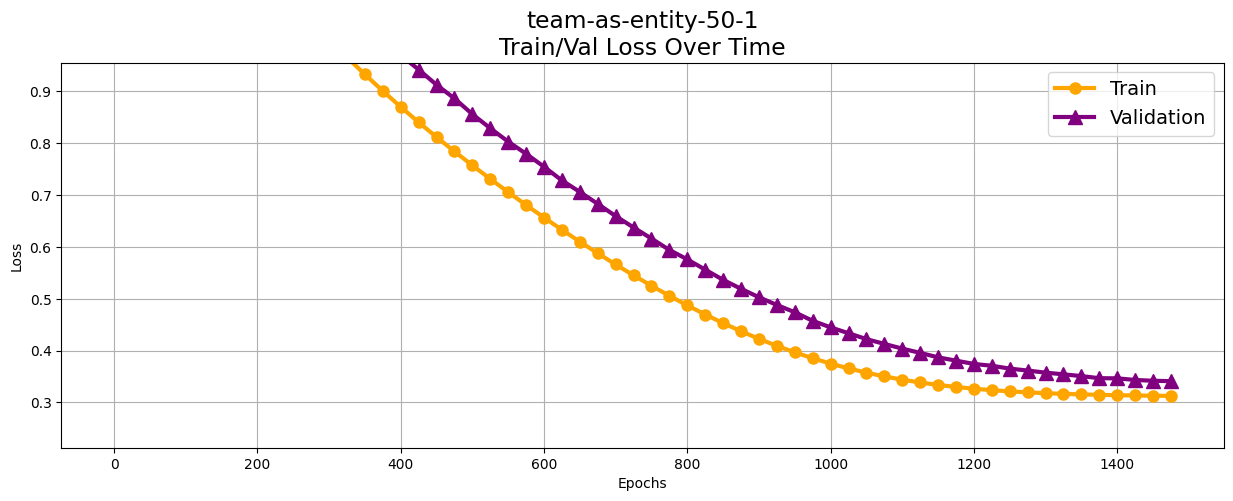

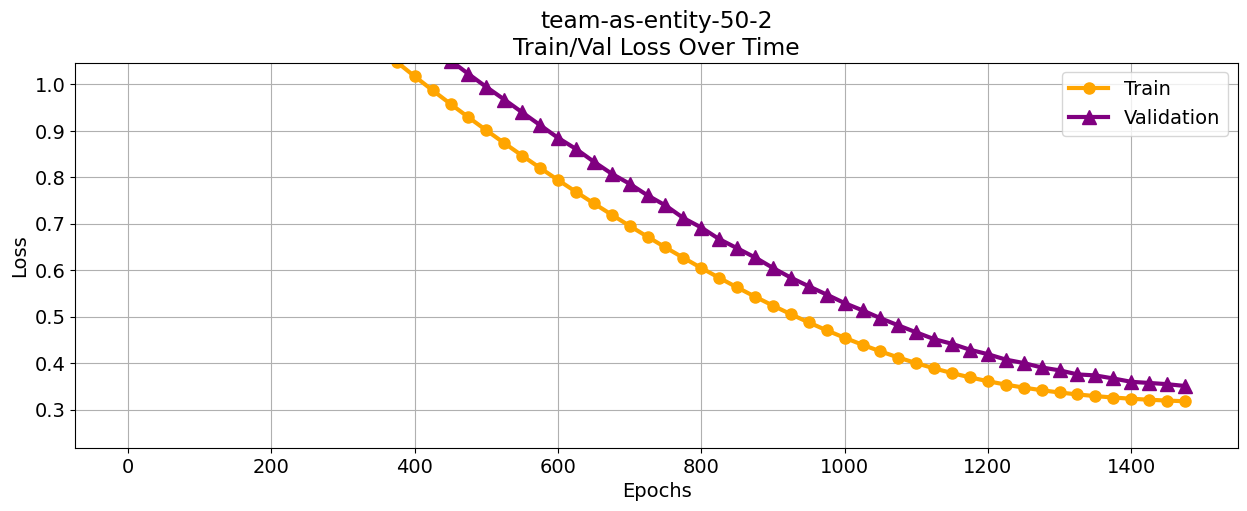

In [11]:
for res in  results:
    plot_train_v_loss(f"team-as-entity-{res[0][0]}-{res[0][1]}", res[1][1], res[1][2], loss_interval)

# Exploration results

Exploration for the team-as-entity model by varying the number of stacked LSTM layers and the number of hidden features. Apparently adding stacked LSTM layers for the same number of hidden features makes the loss decrease slower, but they all reach about the same loss plateau of 0.25. Adding more hidden layers makes the loss decrease faster, but once again it still plateau around 0.25. 

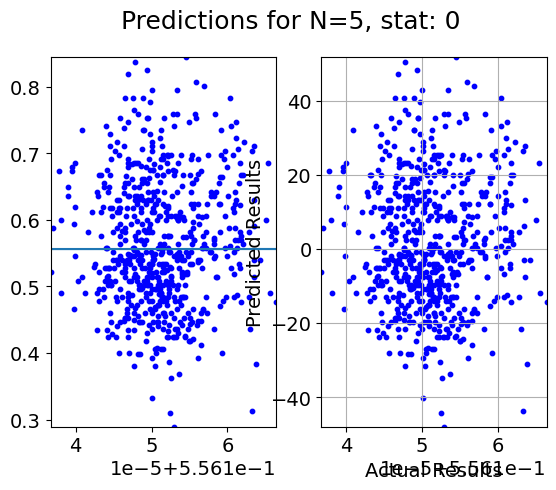

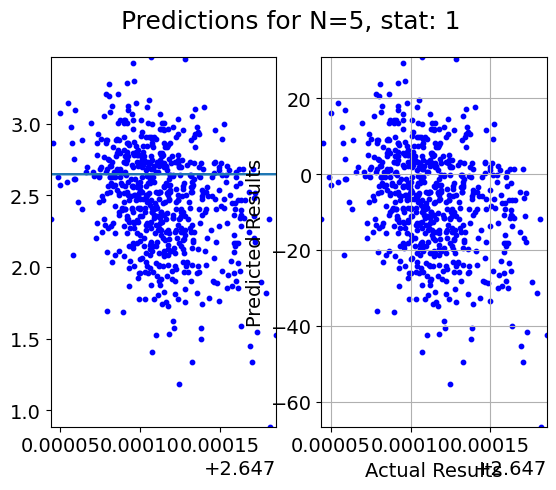

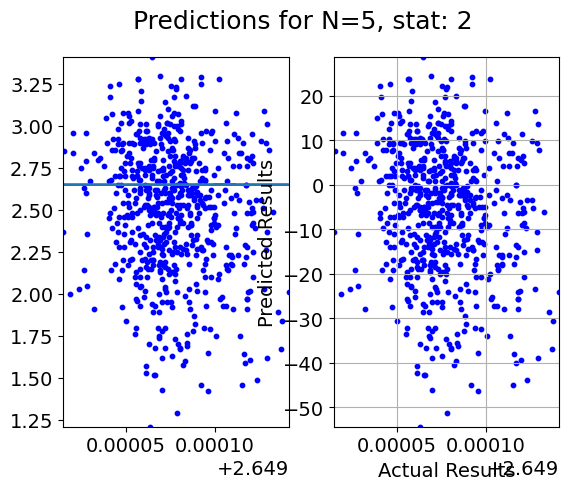

In [12]:
preds_n_targets = get_targets_preds_pairs(dataset, model, device)
plot_divergence(dataset.NL, preds_n_targets, criterion)